# Part 1: Basic NLP

- Chapter 3, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). 

- Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). 

- Adapted from [keras blog](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.5-classifying-movie-reviews.ipynb)



## Setup

In [2]:
!pip install -q tfds-nightly tensorflow matplotlib

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
import os

## Introduction


In this example, we show how to train a simple text classification model.

We'll work with the the following dataset: [AG_news_subset](https://www.tensorflow.org/datasets/catalog/ag_news_subset)

The original AG dataset is a collection of more than 1M news articles.
This subset has been conceived for topic classification and has been constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000.



Label | Class
--- | ---
0 | World
1 | Sports
2 | Business
3 | Sci/Tech


## Download the AG_news_subset


In this lecture we will use TFDS (Tensorflow Datasets): it provides a collection of ready-to-use datasets for use with TensorFlow, Jax, and other Machine Learning frameworks.

Notably, it handles downloading and preparing the data deterministically and constructing np.array or other objects (e.g. tf.data.Dataset).

In [4]:
train_data, train_label = tfds.as_numpy(tfds.load(
    'ag_news_subset',
    split='train', 
    batch_size=-1,  # return the full dataset
    as_supervised=True, # return object and label
))

NonMatchingChecksumError: ignored

If you get a `NonMatchingChecksumError`, try to re-run the cell.
Source: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror

## Workaround

Still not working: load the folders and read from files

In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/CIDL 2020-2021/ag_news_csv' # fix the path
test = pd.read_csv(os.path.join(path,'test.csv'),header = None)
train = pd.read_csv(os.path.join(path,'train.csv'),header = None)
train_data = train[2].values
test_data = test[2].values
train_label = train[0].values-1
test_label = test[0].values-1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


## Let's take a look at the data

In [7]:
train_data.shape

(120000,)

In [8]:
print(train_data[0],train_label[0])
print(train_data[1],train_label[1])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. 2
Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market. 2


In [9]:
type(train_data[0])

str

In [10]:
import matplotlib 
cmap = matplotlib.cm.get_cmap('viridis') # choosing colormaps https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html
evenly_spaced_interval = np.linspace(0, 1, 4)
colors = [cmap(x) for x in evenly_spaced_interval]
colors

[(0.267004, 0.004874, 0.329415, 1.0),
 (0.190631, 0.407061, 0.556089, 1.0),
 (0.20803, 0.718701, 0.472873, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0)]

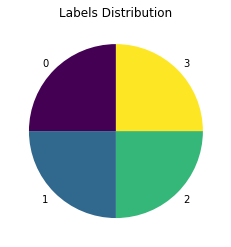

In [11]:
unique, counts = np.unique(train_label, return_counts=True)
plt.pie(counts,labels = unique,startangle = 90,colors=colors)
plt.title('Labels Distribution')
plt.show()
NUM_CLASSES = len(unique)

The classes distribution is perfectly balanced!

In [12]:
train_data[0]

"Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [13]:
train_data[0].split()

['Reuters',
 '-',
 'Short-sellers,',
 'Wall',
 "Street's",
 'dwindling\\band',
 'of',
 'ultra-cynics,',
 'are',
 'seeing',
 'green',
 'again.']

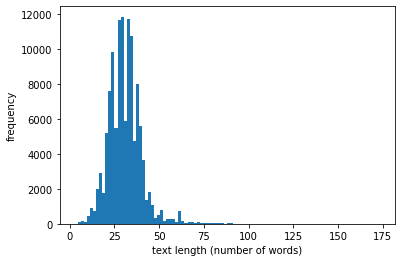

In [14]:
# count the number of "tokens" (units of text) in each article
plt.hist([len(x.split()) for x in train_data],bins = 100)
plt.ylabel("frequency")
plt.xlabel("text length (number of words)")
plt.show()

In [15]:
MAX_WORDS = 10000 #regulates the maximum size of the vocabulary
MAX_LENGTH = 100  #regulates the maximum length of a news article

## Shuffle and split the data into training & validation sets

In [16]:
# Shuffle the data
seed = 123
rng = np.random.RandomState(seed)
rng.shuffle(train_data)
rng = np.random.RandomState(seed)
rng.shuffle(train_label)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(train_data))
text_val = train_data[-num_validation_samples:]
text_train = train_data[:-num_validation_samples]
label_val = train_label[-num_validation_samples:]
label_train = train_label[:-num_validation_samples]

print(label_train[:50]) # check

[1 1 1 3 0 1 0 0 0 2 2 0 1 1 2 1 3 2 3 3 3 1 0 2 2 2 3 0 2 3 3 3 0 1 3 2 2
 1 1 3 1 0 1 1 0 0 1 1 1 2]


## Create a vocabulary index


Like all other neural networks, deep-learning models don’t take as input raw text: they only work with numeric tensors. **Vectorizing** text is the process of **transforming text into numeric tensors**.

Collectively, the different units into which you can break down text (words, characters, or n-grams) are called tokens, and breaking text into such tokens is called tokenization. All text-vectorization processes consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens. These vectors, packed into sequence tensors, are fed into deep neural networks.

### Step by step text processing example: **unconvenient** 

In [17]:
sample = text_train[1]
sample

'ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.'

In [18]:
# Uncomment only if downloaded from tfds-nightly

# # the `b` prefix denotes a **bytes literal**: it produce an instance of the bytes type instead of the str type. 
# # Bytes literal may only contain ASCII characters; bytes with a numeric value of 128 or greater must be expressed with escapes.
# sample = str(sample,"utf-8")
# sample

In [19]:
sample = sample.lower()
sample

'rower sally robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.'

In [20]:
for punct in ',.-;:"'+"'":
  sample = sample.replace(punct," ")
sample

'rower sally robbins #39 s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39 s eight final '

In [21]:
import re
sample = re.sub(' +', ' ', sample)
sample 

'rower sally robbins #39 s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39 s eight final '

In [22]:
sample.split(" ")

['rower',
 'sally',
 'robbins',
 '#39',
 's',
 'teammates',
 'are',
 'expected',
 'to',
 'face',
 'disciplinary',
 'action',
 'for',
 'publicly',
 'criticising',
 'her',
 'failure',
 'to',
 'complete',
 'the',
 'women',
 '#39',
 's',
 'eight',
 'final',
 '']

Actually, there are many other cases that we are not taking into account (e.g. presence of numbers). It is much better resorting to existing text vectorization tools: you will be able to set custom standardization pipeline, if needed.

### Using library utility 


Let's use the `TextVectorization` to index the vocabulary found in the dataset.
Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top 10,000 words, and will truncate or pad sequences to
be actually 100 tokens long.

In [23]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=MAX_WORDS, 
                               output_mode = 'binary',
                               standardize='lower_and_strip_punctuation', # you can also use custom callable, if needed.
                               split="whitespace",
                               ngrams=None, 
                               output_sequence_length=None, 
                               pad_to_max_tokens=True,)
vectorizer.adapt(text_train)

You can retrieve the computed vocabulary used via `vectorizer.get_vocabulary()`. Let's
print the top some words:

In [24]:
len(vectorizer.get_vocabulary())

10000

In [25]:
vectorizer.get_vocabulary()[:10],vectorizer.get_vocabulary()[-4:]

(['[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for', 'that'],
 ['unheralded', 'undermining', 'underdog', 'umpire'])

Let's vectorize a test sentence:

In [26]:
example = "the pen is on a table"
output = vectorizer([[example]])
print(output.numpy().shape)
sum(output.numpy()[0]), output.numpy()[0]

(1, 10000)


(6.0, array([0., 1., 1., ..., 0., 0., 0.], dtype=float32))

As you can see, the vector representation of the sentence is a 10K-dimensional vector of 0s and 1s. We are just checking whether a word appears in the text or not. Since both "the" (index = 1) and "a" (index = 2) appear in the example sentence, the respective positions are set to 1. Note that the first position (index = 0) is reserved for the *out of vocabulary* token (i.e. [UNK]).


![One hot encoding](https://miro.medium.com/max/1420/0*B3rOPw4OVDRSqpU8)`

In [27]:
text_train

array(['AP - No shots, no saves, no goals. The National Hockey League locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by management to gain massive economic change.',
       'ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.',
       'Over at USA Today -- Slogan: "All the News That\'s Fit to Print in Four Paragraphs or Less" -- they got together the last couple of weeks and asked the staff to vote for the "10 things to change in sports."',
       ...,
       'Thai soldiers apprehend hundreds of men after demonstrators clashed with police outside the Tak Bai police station in Thailand #39;s Narathiwat Province, nearly 1150 km (715 miles) south of Bangkok in this picture taken October 25, 2004.',
       'Tommy Tuberville returns to Mississippi with a trip to Atlanta on the line, and he #39;s bringing his b

In [28]:
x_train = vectorizer(np.array([[s] for s in text_train])).numpy()
x_val = vectorizer(np.array([[s] for s in text_val])).numpy()

y_train = np.array(label_train)
y_val = np.array(label_val)

In [29]:
x_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
x_train.shape

(96000, 10000)

This encoding results in a representation of words that is: 
*   sparse (mostly made of zero)
*   high dimensional (same dimensionality as the number of terms in the vocabulary (truncated at 10K in our case)



## Build the model

In [31]:
from tensorflow.keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(MAX_WORDS,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 160,356
Trainable params: 160,356
Non-trainable params: 0
_________________________________________________________________


## Train the model


We use categorical crossentropy as our loss since we're doing softmax classification.

Moreover, we use `sparse_categorical_crossentropy` since our labels are integers.

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4153 - acc: 0.8780 - val_loss: 0.2984 - val_acc: 0.9012
Epoch 2/20
 12/750 [..............................] - ETA: 3s - loss: 0.2530 - acc: 0.9193

KeyboardInterrupt: ignored

In [ ]:
plt.title('ACCURACY')
plt.plot(history.history['acc'],'bo',label = 'Train ')
plt.plot(history.history['val_acc'],'b-',label = 'Val')
plt.legend()
plt.show()

In [ ]:
plt.title('LOSS')
plt.plot(history.history['loss'],'bo',label = 'Train ')
plt.plot(history.history['val_loss'],'b-',label = 'Val')
plt.legend()
plt.show()

As a first outcome, we can note that our model overfits the training set. Yet, we reach an acceptable accuracy of ~90% on the validation set.

# Part 2: Word Embedding

An alternative way to represent words in numerical format is represented by **word embeddings**. The `tf.keras` embedding layer turns positive integers (indexes) into dense vectors of fixed size.



Word embeddings are low dimensional, dense, floating-point vectors, typically learned from data.

<div style="width: 400px;">
<img src="https://camo.githubusercontent.com/8f1074670908ed80281db8c5feeca28d306f1bd8/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368362f776f72645f656d62656464696e67732e706e67" width="400">
</div>

There are two ways to obtain word embeddings:
*   Learn word embeddings jointly with the main task you care about. In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
*   Load into your model word embeddings that were precomputed using a different
machine-learning task than the one you’re trying to solve. These are called *pretrained word embeddings*.

In this notebook we will investigate the former solution.



In [33]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS, 
                               output_mode = 'int', # set different output encoding
                               standardize='lower_and_strip_punctuation',
                               split="whitespace",
                               ngrams=None, 
                               output_sequence_length=MAX_LENGTH, # set max length
                               pad_to_max_tokens=True,)
vectorizer.adapt(text_train)

In [34]:
x_train = vectorizer(np.array([[s] for s in text_train])).numpy()
x_val = vectorizer(np.array([[s] for s in text_val])).numpy()

In [35]:
x_train

array([[  35,   84, 2555, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       [  34,   15, 2330, ...,    0,    0,    0],
       ...,
       [4373,  665,    1, ...,    0,    0,    0],
       [3849,    1, 2838, ...,    0,    0,    0],
       [  35,  598,   21, ...,    0,    0,    0]])

In [36]:
x_train.shape

(96000, 100)

In [37]:
from tensorflow.keras.layers import Embedding
embedding_dim = 16 
embedding_layer = Embedding(
    input_dim = MAX_WORDS, 
    output_dim = embedding_dim, 
    embeddings_initializer='uniform',
    embeddings_regularizer=None, 
    activity_regularizer=None,
    embeddings_constraint=None, 
    mask_zero=True,
    input_length=MAX_LENGTH
)


The `Embedding` layer can be regarded as **a dictionary that maps integer indices (each associated with a specific word) to dense vectors**. It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors. It is effectively a dictionary lookup.

Our embedding layer is randomly initialized: its weights (i.e. word vector representation) are initially random, just as with any other keras layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. 

In [38]:
model = keras.Sequential()
model.add(embedding_layer)
model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 6404      
Total params: 166,404
Trainable params: 166,404
Non-trainable params: 0
_________________________________________________________________


As you can see the `Embedding` layer outputs a 3D tensor of shape `(batch_size, MAX_LENGTH, embedding_dim)`


In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])


Before training our model, we check the cosine distance between word vectors in the embedding space. Remember that they are randomly initialized. The cosine distance is defined as follows:

$$ \mathit{cosine\_distance}(u,v) = 1 - \frac{u \cdot v}{||u||_2 ||v||_2}$$

In [40]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
embedding_weights = model.layers[0].get_weights()[0]
embedding_weights.shape

(10000, 16)

In [41]:
import itertools
from scipy.spatial.distance import cosine

random_distances = {}
my_list = ['football','basketball','ram','cat','dog']
for pair in itertools.combinations(my_list,2):
  v1 = embedding_weights[word_index[pair[0]]]
  v2 = embedding_weights[word_index[pair[1]]]
  random_distances[pair] = cosine(v1,v2)
  print(pair,cosine(v1,v2))

('football', 'basketball') 0.8206060379743576
('football', 'ram') 0.7061623334884644
('football', 'cat') 1.0331241749227047
('football', 'dog') 0.729926347732544
('basketball', 'ram') 0.8884594067931175
('basketball', 'cat') 1.021561972796917
('basketball', 'dog') 0.786055862903595
('ram', 'cat') 0.9579973332583904
('ram', 'dog') 0.9642169997096062
('cat', 'dog') 0.8000230938196182


In [42]:
history = model.fit(x_train, y_train,epochs=20, batch_size=128,validation_data=(x_val, y_val))

Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 0.6346 - acc: 0.7915 - val_loss: 0.3260 - val_acc: 0.8923
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2904 - acc: 0.9040 - val_loss: 0.2896 - val_acc: 0.9036
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2561 - acc: 0.9147 - val_loss: 0.2844 - val_acc: 0.9039
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2386 - acc: 0.9211 - val_loss: 0.2808 - val_acc: 0.9063
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2253 - acc: 0.9258 - val_loss: 0.2825 - val_acc: 0.9057
Epoch 6/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2137 - acc: 0.9299 - val_loss: 0.2841 - val_acc: 0.9066
Epoch 7/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2019 - acc: 0.9346 - val_loss: 0.2857 - val_acc: 0.9045
Epoch 8/20
750/750 [==============================] - 3s 4ms/step - loss: 0.

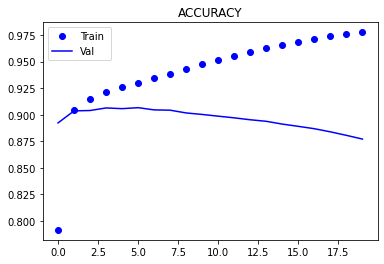

In [43]:
plt.title('ACCURACY')
plt.plot(history.history['acc'],'bo',label = 'Train ')
plt.plot(history.history['val_acc'],'b-',label = 'Val')
plt.legend()
plt.show()

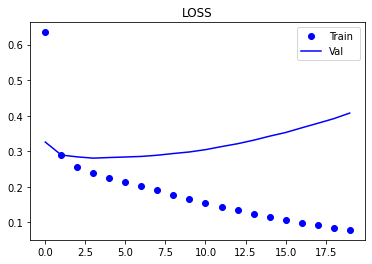

In [44]:
plt.title('LOSS')
plt.plot(history.history['loss'],'bo',label = 'Train ')
plt.plot(history.history['val_loss'],'b-',label = 'Val')
plt.legend()
plt.show()

We can notice a severe overfitting: try to reduce the model capacity or to resort to some regularization technique.


In this example, we are just flattening the embedded sequences; training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure. Yet, our model reaches ~90% accuracy on the validation set.

Indeed, such a basic problem of sentence classification is equally well solved by looking at what words occur in each news article (`binary` or `count` encoding), as we have done in the first part. 

On the other hand such simple architectures turn out to be inadequate for more demanding NLP tasks (e.g. question-answering or machine translation) which require more sophisticated solutions.

Let's check the cosine distance between pairs of word vectors in the learned embedding space. 

In [45]:
embedding_weights = model.layers[0].get_weights()[0]
embedding_weights.shape

my_list = ['football','basketball','ram','cat','dog']
for pair in itertools.combinations(my_list,2):
  v1 = embedding_weights[word_index[pair[0]]]
  v2 = embedding_weights[word_index[pair[1]]]
  print(f"{str(pair):30} {random_distances[pair]:.4f} --> {cosine(v1,v2):.4f}")

('football', 'basketball')     0.8206 --> 0.0340
('football', 'ram')            0.7062 --> 1.1158
('football', 'cat')            1.0331 --> 1.2301
('football', 'dog')            0.7299 --> 0.5319
('basketball', 'ram')          0.8885 --> 1.1730
('basketball', 'cat')          1.0216 --> 1.2602
('basketball', 'dog')          0.7861 --> 0.6414
('ram', 'cat')                 0.9580 --> 0.3276
('ram', 'dog')                 0.9642 --> 0.7548
('cat', 'dog')                 0.8000 --> 0.6708


The `Embedding` layer produces a word vector space that features some interesting properties: words that relate to the same semantic area (e.g. *football* and *basketball*) are close in term of cosine distance.
